# <center> Modelo de Markowitz para Seleção de Portfólio com Rebalanceamento Diário<center>

In [1]:
# required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import Bounds
from scipy.optimize import minimize
from tqdm import tqdm
import yfinance as yf

In [2]:
# Global parameters
ASSETS = pd.Series(['VALE3', 'ITUB4', 'PETR4', 'BBDC4', 'B3SA3', 'PETR3', 'MGLU3', 'ABEV3', 'WEGE3', 'ITSA4', 'BBAS3', 'PCAR3'])
AMOUNT_ASSETS = len(ASSETS) #number of assets to create the portfolio
LEN_TRAIN = 60 #number of past days to train the model
NUM_FRONT_POINT = 4 #amount of number to construct the Pareto front
FRONT_POINTS = np.linspace(0, 1, NUM_FRONT_POINT) #uniform distribution of the weights used in the optimization 
                                                  #to build the Pareto frontier
LEN_SLIDING_WINDOW = 248 #stop criterion
INITIAL_WEALTH = 100000 # portfolio initial wealth

START_2020 = '2019-10-02' #the model takes 60 days for training
                          #the training is repeated daily, it uses the most recent information available through
                          #the sliding window
END_2020 = '2020-12-30'

In [3]:
ibovespa = yf.download(tickers=['^BVSP'], start=START_2020, end = END_2020, rounding=True)['Adj Close']
df_ret_ibovespa_2020 = ibovespa.pct_change()[1:]

[*********************100%***********************]  1 of 1 completed


In [4]:
prices = yf.download(tickers=(ASSETS + '.SA').tolist(), start=START_2020, end= END_2020, rounding=True)['Adj Close']
prices.columns = prices.columns.str.rstrip('.SA')  # removes the .SA from the asset's name
df_ret_2020 = prices.pct_change()[1:]
#df_ret_2020.fillna(method="backfill",inplace = True)

[*********************100%***********************]  12 of 12 completed


# Constraints

In [5]:
# Definition of the investment bound constraint
bounds = Bounds(np.zeros(AMOUNT_ASSETS), np.ones(AMOUNT_ASSETS))

- Remember that, in general, we only work with the constraint `$≤$`.
- So it is necessary to make an **“adaptation”** in the way of writing the constraints defined by `$≥$`.

In [6]:
# b1    <= A * x   <==>   -b1 >= -A*x        <==>   A*x - b1 >= 0
# A * x <= b2      <==>    A*x - b2 <= 0     <==>  -Ax + b2 >= 0
A = np.ones(AMOUNT_ASSETS)
b = np.array([1])

cons = [{"type": "ineq", "fun": lambda x: A @ x - b}, {"type": "ineq", "fun": lambda x: -A @ x + b}]

In [7]:
# initial condition: the naive portfolio
U0 = 1/AMOUNT_ASSETS*np.ones(AMOUNT_ASSETS)

# Optimization method

In [8]:
# Defines the objective functions (return and risk)
# Takes the weight to be used in the weighted combination using the parameter aux_ponto_front
# Returns the optimal portfolio came from the weight optimization considering the weight aux_dot_front
def get_optimize(aux_ponto_front, aux_train_return):
    
    def f(U,front_point = aux_ponto_front,train_return = aux_train_return):
        #train_return=returns[0:LEN_TRAIN-1]
        mean_return = train_return.mean()
        portfolio_return = mean_return.values.dot(U)
        portfolio_risk = (U.dot(np.cov(train_return.T))).dot(U)
        return front_point*portfolio_risk-(1-front_point)*portfolio_return

    Umin = minimize(f, U0, args=(),method='SLSQP',  jac=None, bounds=bounds, constraints=cons, 
                    tol=None,callback=None,options={'maxiter': 1000, 'ftol': 1e-16, 'iprint': 0,'eps': 1e-8})    
    return Umin.x

In [9]:
# Gets the portfolio return and risk obtained by the optimal portfolio
def get_return_risk(portfolio,train_return):
    mean_return = train_return.mean()
    portfolio_return = mean_return.values.dot(portfolio)
    portfolio_risk = (portfolio.dot(np.cov(train_return.T))).dot(portfolio)
    return portfolio_return, portfolio_risk

In [10]:
# Runs the problem
#Input data: the DataFrame daily return
#Output data: the daily optimal portfolio for the complete period

#Proceding: at each time instant k:
# Step_1: the model is trained using the last 60 past days.
# Step_2: the weighted optimization w*portfolio_risk-(1-w)*portfolio_return is runned using the SLSQP method.
    # the parameter w is a weight in [0,1]
    # a Pareto front is generated
#Step_3: chose a Pareto front point to be applied to the system
    # we chose the Pareto front midpoint, which is the investment adviser to a moderate profile investor
    # another choice criterion can be setted
#Step_4: Updates the system with the newest information from the real world
    # the oldest information is discarded
#Step_5: if the stop criterion is done
            #break
        #else
            #go to Step_1
def run_problem(df_ret):
    num_otim = 0
    selected_portfolios = pd.DataFrame([], index=np.arange(0, AMOUNT_ASSETS), columns=['Day_' + str(day) for day in range(LEN_SLIDING_WINDOW)])
    for k in tqdm(range(LEN_TRAIN, LEN_TRAIN+ LEN_SLIDING_WINDOW)):
        df_train = df_ret[k - LEN_TRAIN:k-1]
        front_portfolios = []
        for front_point in FRONT_POINTS:
            portfolio = get_optimize(front_point, df_train)
            front_portfolios.append(portfolio) 
        pos = int(NUM_FRONT_POINT/2) #choose the Pareto front midpoint ----> Moderate profile   
        selected_portfolio = front_portfolios[pos]
        selected_portfolios['Day_' + str(num_otim)] = pd.DataFrame(np.matrix(selected_portfolio)).T
        num_otim +=1
        print(k)
    selected_portfolios.index = df_ret.columns
    selected_portfolios.columns = df_ret[LEN_TRAIN-1:LEN_TRAIN+LEN_SLIDING_WINDOW-1].index    
    return selected_portfolios

In [11]:
# Uses the daily optimal portfolio to define the portfolio daily rentability 
def get_rentability(df_ret, selected_portfolios):
    dates = selected_portfolios.columns
    cont = 0
    rentability = pd.DataFrame([], index = dates, columns = ['Rentability'])
    for k in range(LEN_TRAIN, LEN_TRAIN+LEN_SLIDING_WINDOW):
        next_day_return = df_ret[k-1:k]
        rentability['Rentability'][cont] = next_day_return.values[0].dot(selected_portfolios[dates[cont]].values)
        cont +=1
    return rentability 

In [12]:
# Get's the cumulative wealth
def get_cumulative_wealth(rentability):
    cum_rent = pd.DataFrame([], index = rentability.index, columns = ['Cumulative Wealth'])
    cum_rent['Cumulative Wealth'] = INITIAL_WEALTH*np.cumprod(1 + rentability['Rentability'].values) - 1
    return cum_rent

In [13]:
#Runs the problem for 2020
selected_portfolios_2020 = run_problem(df_ret_2020)
rentability_2020 = get_rentability(df_ret_2020, selected_portfolios_2020)
aux_cumulative_wealth_2020 = get_cumulative_wealth(rentability_2020)
first_day_2020 = pd.DataFrame([INITIAL_WEALTH], index =['2019-12-30 00:00:00'], columns = ['Cumulative Wealth'])
cumulative_wealth_2020 = first_day_2020.append(aux_cumulative_wealth_2020)

  0%|▎                                                                                 | 1/248 [00:01<06:26,  1.57s/it]

60


  1%|▋                                                                                 | 2/248 [00:03<06:42,  1.64s/it]

61


  1%|▉                                                                                 | 3/248 [00:05<08:19,  2.04s/it]

62


  2%|█▎                                                                                | 4/248 [00:07<07:44,  1.90s/it]

63


  2%|█▋                                                                                | 5/248 [00:08<06:38,  1.64s/it]

64


  2%|█▉                                                                                | 6/248 [00:10<06:17,  1.56s/it]

65


  3%|██▎                                                                               | 7/248 [00:11<05:43,  1.42s/it]

66


  3%|██▋                                                                               | 8/248 [00:12<05:37,  1.41s/it]

67


  4%|██▉                                                                               | 9/248 [00:14<05:41,  1.43s/it]

68


  4%|███▎                                                                             | 10/248 [00:15<05:36,  1.41s/it]

69


  4%|███▌                                                                             | 11/248 [00:16<05:12,  1.32s/it]

70


  5%|███▉                                                                             | 12/248 [00:18<05:44,  1.46s/it]

71


  5%|████▏                                                                            | 13/248 [00:19<05:14,  1.34s/it]

72


  6%|████▌                                                                            | 14/248 [00:20<04:57,  1.27s/it]

73


  6%|████▉                                                                            | 15/248 [00:22<05:30,  1.42s/it]

74


  6%|█████▏                                                                           | 16/248 [00:23<04:52,  1.26s/it]

75


  7%|█████▌                                                                           | 17/248 [00:25<06:01,  1.57s/it]

76


  7%|█████▉                                                                           | 18/248 [00:26<05:41,  1.49s/it]

77


  8%|██████▏                                                                          | 19/248 [00:28<05:34,  1.46s/it]

78


  8%|██████▌                                                                          | 20/248 [00:29<05:06,  1.34s/it]

79


  8%|██████▊                                                                          | 21/248 [00:30<04:30,  1.19s/it]

80


  9%|███████▏                                                                         | 22/248 [00:31<04:24,  1.17s/it]

81


  9%|███████▌                                                                         | 23/248 [00:32<04:48,  1.28s/it]

82


 10%|███████▊                                                                         | 24/248 [00:33<04:29,  1.20s/it]

83


 10%|████████▏                                                                        | 25/248 [00:34<04:18,  1.16s/it]

84


 10%|████████▍                                                                        | 26/248 [00:35<04:10,  1.13s/it]

85


 11%|████████▊                                                                        | 27/248 [00:37<04:14,  1.15s/it]

86


 11%|█████████▏                                                                       | 28/248 [00:38<04:37,  1.26s/it]

87


 12%|█████████▍                                                                       | 29/248 [00:39<04:41,  1.29s/it]

88


 12%|█████████▊                                                                       | 30/248 [00:40<04:17,  1.18s/it]

89


 12%|██████████▏                                                                      | 31/248 [00:41<04:08,  1.14s/it]

90


 13%|██████████▍                                                                      | 32/248 [00:43<04:13,  1.17s/it]

91


 13%|██████████▊                                                                      | 33/248 [00:44<03:55,  1.10s/it]

92


 14%|███████████                                                                      | 34/248 [00:44<03:45,  1.05s/it]

93


 14%|███████████▍                                                                     | 35/248 [00:45<03:40,  1.03s/it]

94


 15%|███████████▊                                                                     | 36/248 [00:46<03:37,  1.02s/it]

95


 15%|████████████                                                                     | 37/248 [00:49<05:23,  1.53s/it]

96


 15%|████████████▍                                                                    | 38/248 [00:50<04:43,  1.35s/it]

97


 16%|████████████▋                                                                    | 39/248 [00:51<04:33,  1.31s/it]

98


 16%|█████████████                                                                    | 40/248 [00:52<04:02,  1.16s/it]

99


 17%|█████████████▍                                                                   | 41/248 [00:53<03:49,  1.11s/it]

100


 17%|█████████████▋                                                                   | 42/248 [00:54<03:41,  1.07s/it]

101


 17%|██████████████                                                                   | 43/248 [00:55<03:28,  1.02s/it]

102


 18%|██████████████▎                                                                  | 44/248 [00:56<03:41,  1.08s/it]

103


 18%|██████████████▋                                                                  | 45/248 [00:57<03:26,  1.02s/it]

104


 19%|███████████████                                                                  | 46/248 [00:59<04:00,  1.19s/it]

105


 19%|███████████████▎                                                                 | 47/248 [01:00<03:46,  1.13s/it]

106


 19%|███████████████▋                                                                 | 48/248 [01:00<03:20,  1.00s/it]

107


 20%|████████████████                                                                 | 49/248 [01:01<03:07,  1.06it/s]

108


 20%|████████████████▎                                                                | 50/248 [01:02<02:53,  1.14it/s]

109


 21%|████████████████▋                                                                | 51/248 [01:03<02:47,  1.18it/s]

110


 21%|████████████████▉                                                                | 52/248 [01:04<02:45,  1.18it/s]

111


 21%|█████████████████▎                                                               | 53/248 [01:05<02:54,  1.12it/s]

112


 22%|█████████████████▋                                                               | 54/248 [01:05<02:54,  1.11it/s]

113


 22%|█████████████████▉                                                               | 55/248 [01:06<02:45,  1.17it/s]

114


 23%|██████████████████▎                                                              | 56/248 [01:07<02:53,  1.11it/s]

115


 23%|██████████████████▌                                                              | 57/248 [01:08<02:46,  1.15it/s]

116


 23%|██████████████████▉                                                              | 58/248 [01:09<02:33,  1.24it/s]

117


 24%|███████████████████▎                                                             | 59/248 [01:09<02:29,  1.26it/s]

118


 24%|███████████████████▌                                                             | 60/248 [01:10<02:27,  1.27it/s]

119


 25%|███████████████████▉                                                             | 61/248 [01:11<02:26,  1.28it/s]

120


 25%|████████████████████▎                                                            | 62/248 [01:12<02:26,  1.27it/s]

121


 25%|████████████████████▌                                                            | 63/248 [01:13<02:39,  1.16it/s]

122


 26%|████████████████████▉                                                            | 64/248 [01:14<02:34,  1.19it/s]

123


 26%|█████████████████████▏                                                           | 65/248 [01:15<02:42,  1.13it/s]

124


 27%|█████████████████████▌                                                           | 66/248 [01:15<02:34,  1.18it/s]

125


 27%|█████████████████████▉                                                           | 67/248 [01:16<02:28,  1.22it/s]

126


 27%|██████████████████████▏                                                          | 68/248 [01:17<02:21,  1.27it/s]

127


 28%|██████████████████████▌                                                          | 69/248 [01:17<02:12,  1.35it/s]

128


 28%|██████████████████████▊                                                          | 70/248 [01:18<02:08,  1.38it/s]

129


 29%|███████████████████████▏                                                         | 71/248 [01:19<02:10,  1.36it/s]

130


 29%|███████████████████████▌                                                         | 72/248 [01:20<02:13,  1.32it/s]

131


 29%|███████████████████████▊                                                         | 73/248 [01:21<02:14,  1.30it/s]

132


 30%|████████████████████████▏                                                        | 74/248 [01:21<02:13,  1.30it/s]

133


 30%|████████████████████████▍                                                        | 75/248 [01:22<02:17,  1.26it/s]

134


 31%|████████████████████████▊                                                        | 76/248 [01:23<02:19,  1.23it/s]

135


 31%|█████████████████████████▏                                                       | 77/248 [01:24<02:21,  1.21it/s]

136


 31%|█████████████████████████▍                                                       | 78/248 [01:25<02:20,  1.21it/s]

137


 32%|█████████████████████████▊                                                       | 79/248 [01:26<02:20,  1.20it/s]

138


 32%|██████████████████████████▏                                                      | 80/248 [01:26<02:17,  1.22it/s]

139


 33%|██████████████████████████▍                                                      | 81/248 [01:27<02:14,  1.24it/s]

140


 33%|██████████████████████████▊                                                      | 82/248 [01:28<02:10,  1.27it/s]

141


 33%|███████████████████████████                                                      | 83/248 [01:29<02:08,  1.28it/s]

142


 34%|███████████████████████████▍                                                     | 84/248 [01:29<02:11,  1.25it/s]

143


 34%|███████████████████████████▊                                                     | 85/248 [01:31<02:23,  1.14it/s]

144


 35%|████████████████████████████                                                     | 86/248 [01:31<02:23,  1.13it/s]

145


 35%|████████████████████████████▍                                                    | 87/248 [01:32<02:16,  1.18it/s]

146


 35%|████████████████████████████▋                                                    | 88/248 [01:33<02:11,  1.22it/s]

147


 36%|█████████████████████████████                                                    | 89/248 [01:34<02:12,  1.20it/s]

148


 36%|█████████████████████████████▍                                                   | 90/248 [01:35<02:10,  1.21it/s]

149


 37%|█████████████████████████████▋                                                   | 91/248 [01:35<02:08,  1.22it/s]

150


 37%|██████████████████████████████                                                   | 92/248 [01:36<02:09,  1.20it/s]

151


 38%|██████████████████████████████▍                                                  | 93/248 [01:37<02:13,  1.16it/s]

152


 38%|██████████████████████████████▋                                                  | 94/248 [01:38<02:21,  1.09it/s]

153


 38%|███████████████████████████████                                                  | 95/248 [01:39<02:16,  1.12it/s]

154


 39%|███████████████████████████████▎                                                 | 96/248 [01:40<02:15,  1.12it/s]

155


 39%|███████████████████████████████▋                                                 | 97/248 [01:41<02:14,  1.12it/s]

156


 40%|████████████████████████████████                                                 | 98/248 [01:42<02:12,  1.13it/s]

157


 40%|████████████████████████████████▎                                                | 99/248 [01:43<02:15,  1.10it/s]

158


 40%|████████████████████████████████▎                                               | 100/248 [01:44<02:20,  1.05it/s]

159


 41%|████████████████████████████████▌                                               | 101/248 [01:45<02:15,  1.08it/s]

160


 41%|████████████████████████████████▉                                               | 102/248 [01:45<02:10,  1.12it/s]

161


 42%|█████████████████████████████████▏                                              | 103/248 [01:46<02:09,  1.12it/s]

162


 42%|█████████████████████████████████▌                                              | 104/248 [01:47<02:19,  1.04it/s]

163


 42%|█████████████████████████████████▊                                              | 105/248 [01:48<02:21,  1.01it/s]

164


 43%|██████████████████████████████████▏                                             | 106/248 [01:50<02:28,  1.05s/it]

165


 43%|██████████████████████████████████▌                                             | 107/248 [01:51<02:33,  1.09s/it]

166


 44%|██████████████████████████████████▊                                             | 108/248 [01:52<02:25,  1.04s/it]

167


 44%|███████████████████████████████████▏                                            | 109/248 [01:53<02:25,  1.05s/it]

168


 44%|███████████████████████████████████▍                                            | 110/248 [01:54<02:25,  1.05s/it]

169


 45%|███████████████████████████████████▊                                            | 111/248 [01:56<03:05,  1.36s/it]

170


 45%|████████████████████████████████████▏                                           | 112/248 [01:57<02:51,  1.26s/it]

171


 46%|████████████████████████████████████▍                                           | 113/248 [01:58<02:45,  1.22s/it]

172


 46%|████████████████████████████████████▊                                           | 114/248 [01:59<02:38,  1.18s/it]

173


 46%|█████████████████████████████████████                                           | 115/248 [02:00<02:38,  1.19s/it]

174


 47%|█████████████████████████████████████▍                                          | 116/248 [02:01<02:24,  1.09s/it]

175


 47%|█████████████████████████████████████▋                                          | 117/248 [02:02<02:15,  1.03s/it]

176


 48%|██████████████████████████████████████                                          | 118/248 [02:04<02:33,  1.18s/it]

177


 48%|██████████████████████████████████████▍                                         | 119/248 [02:05<02:27,  1.14s/it]

178


 48%|██████████████████████████████████████▋                                         | 120/248 [02:06<02:23,  1.12s/it]

179


 49%|███████████████████████████████████████                                         | 121/248 [02:07<02:32,  1.20s/it]

180


 49%|███████████████████████████████████████▎                                        | 122/248 [02:08<02:21,  1.13s/it]

181


 50%|███████████████████████████████████████▋                                        | 123/248 [02:10<02:31,  1.21s/it]

182


 50%|████████████████████████████████████████                                        | 124/248 [02:11<02:39,  1.29s/it]

183


 50%|████████████████████████████████████████▎                                       | 125/248 [02:12<02:27,  1.20s/it]

184


 51%|████████████████████████████████████████▋                                       | 126/248 [02:13<02:14,  1.10s/it]

185


 51%|████████████████████████████████████████▉                                       | 127/248 [02:15<02:33,  1.27s/it]

186


 52%|█████████████████████████████████████████▎                                      | 128/248 [02:17<02:55,  1.46s/it]

187


 52%|█████████████████████████████████████████▌                                      | 129/248 [02:19<03:25,  1.73s/it]

188


 52%|█████████████████████████████████████████▉                                      | 130/248 [02:20<03:17,  1.67s/it]

189


 53%|██████████████████████████████████████████▎                                     | 131/248 [02:21<02:46,  1.43s/it]

190


 53%|██████████████████████████████████████████▌                                     | 132/248 [02:23<02:41,  1.39s/it]

191


 54%|██████████████████████████████████████████▉                                     | 133/248 [02:24<02:30,  1.31s/it]

192


 54%|███████████████████████████████████████████▏                                    | 134/248 [02:26<02:50,  1.50s/it]

193


 54%|███████████████████████████████████████████▌                                    | 135/248 [02:27<02:43,  1.44s/it]

194


 55%|███████████████████████████████████████████▊                                    | 136/248 [02:29<02:55,  1.56s/it]

195


 55%|████████████████████████████████████████████▏                                   | 137/248 [02:30<02:55,  1.58s/it]

196


 56%|████████████████████████████████████████████▌                                   | 138/248 [02:31<02:36,  1.42s/it]

197


 56%|████████████████████████████████████████████▊                                   | 139/248 [02:33<02:25,  1.33s/it]

198


 56%|█████████████████████████████████████████████▏                                  | 140/248 [02:34<02:16,  1.27s/it]

199


 57%|█████████████████████████████████████████████▍                                  | 141/248 [02:35<02:09,  1.21s/it]

200


 57%|█████████████████████████████████████████████▊                                  | 142/248 [02:36<02:12,  1.25s/it]

201


 58%|██████████████████████████████████████████████▏                                 | 143/248 [02:37<02:05,  1.20s/it]

202


 58%|██████████████████████████████████████████████▍                                 | 144/248 [02:39<02:10,  1.26s/it]

203


 58%|██████████████████████████████████████████████▊                                 | 145/248 [02:40<02:22,  1.38s/it]

204


 59%|███████████████████████████████████████████████                                 | 146/248 [02:41<02:17,  1.34s/it]

205


 59%|███████████████████████████████████████████████▍                                | 147/248 [02:43<02:31,  1.50s/it]

206


 60%|███████████████████████████████████████████████▋                                | 148/248 [02:45<02:27,  1.48s/it]

207


 60%|████████████████████████████████████████████████                                | 149/248 [02:46<02:21,  1.43s/it]

208


 60%|████████████████████████████████████████████████▍                               | 150/248 [02:47<02:05,  1.28s/it]

209


 61%|████████████████████████████████████████████████▋                               | 151/248 [02:48<02:05,  1.29s/it]

210


 61%|█████████████████████████████████████████████████                               | 152/248 [02:49<01:52,  1.17s/it]

211


 62%|█████████████████████████████████████████████████▎                              | 153/248 [02:50<01:45,  1.11s/it]

212


 62%|█████████████████████████████████████████████████▋                              | 154/248 [02:52<02:05,  1.33s/it]

213


 62%|██████████████████████████████████████████████████                              | 155/248 [02:53<01:58,  1.27s/it]

214


 63%|██████████████████████████████████████████████████▎                             | 156/248 [02:54<01:42,  1.12s/it]

215


 63%|██████████████████████████████████████████████████▋                             | 157/248 [02:55<01:41,  1.11s/it]

216


 64%|██████████████████████████████████████████████████▉                             | 158/248 [02:57<02:04,  1.39s/it]

217


 64%|███████████████████████████████████████████████████▎                            | 159/248 [02:58<01:55,  1.30s/it]

218


 65%|███████████████████████████████████████████████████▌                            | 160/248 [03:00<01:57,  1.33s/it]

219


 65%|███████████████████████████████████████████████████▉                            | 161/248 [03:01<01:53,  1.31s/it]

220


 65%|████████████████████████████████████████████████████▎                           | 162/248 [03:02<01:47,  1.25s/it]

221


 66%|████████████████████████████████████████████████████▌                           | 163/248 [03:03<01:51,  1.31s/it]

222


 66%|████████████████████████████████████████████████████▉                           | 164/248 [03:04<01:43,  1.23s/it]

223


 67%|█████████████████████████████████████████████████████▏                          | 165/248 [03:05<01:37,  1.17s/it]

224


 67%|█████████████████████████████████████████████████████▌                          | 166/248 [03:07<01:32,  1.13s/it]

225


 67%|█████████████████████████████████████████████████████▊                          | 167/248 [03:08<01:31,  1.13s/it]

226


 68%|██████████████████████████████████████████████████████▏                         | 168/248 [03:09<01:27,  1.09s/it]

227


 68%|██████████████████████████████████████████████████████▌                         | 169/248 [03:10<01:26,  1.09s/it]

228


 69%|██████████████████████████████████████████████████████▊                         | 170/248 [03:11<01:22,  1.06s/it]

229


 69%|███████████████████████████████████████████████████████▏                        | 171/248 [03:12<01:20,  1.05s/it]

230


 69%|███████████████████████████████████████████████████████▍                        | 172/248 [03:13<01:25,  1.12s/it]

231


 70%|███████████████████████████████████████████████████████▊                        | 173/248 [03:14<01:25,  1.13s/it]

232


 70%|████████████████████████████████████████████████████████▏                       | 174/248 [03:15<01:24,  1.14s/it]

233


 71%|████████████████████████████████████████████████████████▍                       | 175/248 [03:17<01:28,  1.22s/it]

234


 71%|████████████████████████████████████████████████████████▊                       | 176/248 [03:18<01:26,  1.20s/it]

235


 71%|█████████████████████████████████████████████████████████                       | 177/248 [03:20<01:33,  1.32s/it]

236


 72%|█████████████████████████████████████████████████████████▍                      | 178/248 [03:21<01:37,  1.39s/it]

237


 72%|█████████████████████████████████████████████████████████▋                      | 179/248 [03:22<01:32,  1.34s/it]

238


 73%|██████████████████████████████████████████████████████████                      | 180/248 [03:24<01:32,  1.36s/it]

239


 73%|██████████████████████████████████████████████████████████▍                     | 181/248 [03:25<01:28,  1.32s/it]

240


 73%|██████████████████████████████████████████████████████████▋                     | 182/248 [03:26<01:24,  1.29s/it]

241


 74%|███████████████████████████████████████████████████████████                     | 183/248 [03:28<01:31,  1.41s/it]

242


 74%|███████████████████████████████████████████████████████████▎                    | 184/248 [03:29<01:25,  1.33s/it]

243


 75%|███████████████████████████████████████████████████████████▋                    | 185/248 [03:30<01:18,  1.25s/it]

244


 75%|████████████████████████████████████████████████████████████                    | 186/248 [03:31<01:13,  1.18s/it]

245


 75%|████████████████████████████████████████████████████████████▎                   | 187/248 [03:32<01:08,  1.12s/it]

246


 76%|████████████████████████████████████████████████████████████▋                   | 188/248 [03:33<01:07,  1.13s/it]

247


 76%|████████████████████████████████████████████████████████████▉                   | 189/248 [03:34<01:05,  1.11s/it]

248


 77%|█████████████████████████████████████████████████████████████▎                  | 190/248 [03:35<01:03,  1.10s/it]

249


 77%|█████████████████████████████████████████████████████████████▌                  | 191/248 [03:36<01:01,  1.08s/it]

250


 77%|█████████████████████████████████████████████████████████████▉                  | 192/248 [03:38<01:08,  1.22s/it]

251


 78%|██████████████████████████████████████████████████████████████▎                 | 193/248 [03:39<01:02,  1.14s/it]

252


 78%|██████████████████████████████████████████████████████████████▌                 | 194/248 [03:40<00:59,  1.10s/it]

253


 79%|██████████████████████████████████████████████████████████████▉                 | 195/248 [03:42<01:08,  1.29s/it]

254


 79%|███████████████████████████████████████████████████████████████▏                | 196/248 [03:42<01:00,  1.16s/it]

255


 79%|███████████████████████████████████████████████████████████████▌                | 197/248 [03:44<00:59,  1.17s/it]

256


 80%|███████████████████████████████████████████████████████████████▊                | 198/248 [03:45<01:06,  1.32s/it]

257


 80%|████████████████████████████████████████████████████████████████▏               | 199/248 [03:47<01:15,  1.54s/it]

258


 81%|████████████████████████████████████████████████████████████████▌               | 200/248 [03:49<01:13,  1.53s/it]

259


 81%|████████████████████████████████████████████████████████████████▊               | 201/248 [03:50<01:03,  1.35s/it]

260


 81%|█████████████████████████████████████████████████████████████████▏              | 202/248 [03:51<01:04,  1.40s/it]

261


 82%|█████████████████████████████████████████████████████████████████▍              | 203/248 [03:52<00:57,  1.27s/it]

262


 82%|█████████████████████████████████████████████████████████████████▊              | 204/248 [03:54<00:58,  1.33s/it]

263


 83%|██████████████████████████████████████████████████████████████████▏             | 205/248 [03:55<00:52,  1.23s/it]

264


 83%|██████████████████████████████████████████████████████████████████▍             | 206/248 [03:56<00:49,  1.19s/it]

265


 83%|██████████████████████████████████████████████████████████████████▊             | 207/248 [03:57<00:49,  1.20s/it]

266


 84%|███████████████████████████████████████████████████████████████████             | 208/248 [03:58<00:46,  1.17s/it]

267


 84%|███████████████████████████████████████████████████████████████████▍            | 209/248 [03:59<00:44,  1.14s/it]

268


 85%|███████████████████████████████████████████████████████████████████▋            | 210/248 [04:00<00:43,  1.15s/it]

269


 85%|████████████████████████████████████████████████████████████████████            | 211/248 [04:02<00:42,  1.14s/it]

270


 85%|████████████████████████████████████████████████████████████████████▍           | 212/248 [04:04<00:50,  1.40s/it]

271


 86%|████████████████████████████████████████████████████████████████████▋           | 213/248 [04:04<00:43,  1.24s/it]

272


 86%|█████████████████████████████████████████████████████████████████████           | 214/248 [04:06<00:43,  1.27s/it]

273


 87%|█████████████████████████████████████████████████████████████████████▎          | 215/248 [04:07<00:46,  1.41s/it]

274


 87%|█████████████████████████████████████████████████████████████████████▋          | 216/248 [04:09<00:47,  1.48s/it]

275


 88%|██████████████████████████████████████████████████████████████████████          | 217/248 [04:10<00:44,  1.43s/it]

276


 88%|██████████████████████████████████████████████████████████████████████▎         | 218/248 [04:12<00:40,  1.36s/it]

277


 88%|██████████████████████████████████████████████████████████████████████▋         | 219/248 [04:14<00:43,  1.51s/it]

278


 89%|██████████████████████████████████████████████████████████████████████▉         | 220/248 [04:15<00:41,  1.48s/it]

279


 89%|███████████████████████████████████████████████████████████████████████▎        | 221/248 [04:16<00:38,  1.43s/it]

280


 90%|███████████████████████████████████████████████████████████████████████▌        | 222/248 [04:18<00:40,  1.55s/it]

281


 90%|███████████████████████████████████████████████████████████████████████▉        | 223/248 [04:20<00:38,  1.53s/it]

282


 90%|████████████████████████████████████████████████████████████████████████▎       | 224/248 [04:21<00:34,  1.45s/it]

283


 91%|████████████████████████████████████████████████████████████████████████▌       | 225/248 [04:23<00:35,  1.54s/it]

284


 91%|████████████████████████████████████████████████████████████████████████▉       | 226/248 [04:25<00:39,  1.79s/it]

285


 92%|█████████████████████████████████████████████████████████████████████████▏      | 227/248 [04:26<00:35,  1.69s/it]

286


 92%|█████████████████████████████████████████████████████████████████████████▌      | 228/248 [04:28<00:34,  1.71s/it]

287


 92%|█████████████████████████████████████████████████████████████████████████▊      | 229/248 [04:29<00:29,  1.54s/it]

288


 93%|██████████████████████████████████████████████████████████████████████████▏     | 230/248 [04:31<00:26,  1.45s/it]

289


 93%|██████████████████████████████████████████████████████████████████████████▌     | 231/248 [04:32<00:27,  1.60s/it]

290


 94%|██████████████████████████████████████████████████████████████████████████▊     | 232/248 [04:34<00:23,  1.45s/it]

291


 94%|███████████████████████████████████████████████████████████████████████████▏    | 233/248 [04:37<00:28,  1.90s/it]

292


 94%|███████████████████████████████████████████████████████████████████████████▍    | 234/248 [04:38<00:23,  1.66s/it]

293


 95%|███████████████████████████████████████████████████████████████████████████▊    | 235/248 [04:39<00:20,  1.57s/it]

294


 95%|████████████████████████████████████████████████████████████████████████████▏   | 236/248 [04:40<00:16,  1.41s/it]

295


 96%|████████████████████████████████████████████████████████████████████████████▍   | 237/248 [04:42<00:16,  1.47s/it]

296


 96%|████████████████████████████████████████████████████████████████████████████▊   | 238/248 [04:43<00:13,  1.39s/it]

297


 96%|█████████████████████████████████████████████████████████████████████████████   | 239/248 [04:44<00:12,  1.41s/it]

298


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 240/248 [04:46<00:12,  1.59s/it]

299


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 241/248 [04:47<00:09,  1.42s/it]

300


 98%|██████████████████████████████████████████████████████████████████████████████  | 242/248 [04:49<00:09,  1.63s/it]

301


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 243/248 [04:51<00:07,  1.52s/it]

302


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 244/248 [04:52<00:05,  1.44s/it]

303


 99%|███████████████████████████████████████████████████████████████████████████████ | 245/248 [04:54<00:04,  1.55s/it]

304


 99%|███████████████████████████████████████████████████████████████████████████████▎| 246/248 [04:55<00:03,  1.52s/it]

305


100%|███████████████████████████████████████████████████████████████████████████████▋| 247/248 [04:57<00:01,  1.50s/it]

306


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [04:59<00:00,  1.21s/it]

307


In [14]:
# Get's the Ibovespa cumulative wealth for 2020
cumulative_wealth_2020.index = pd.to_datetime(cumulative_wealth_2020.index)
aux_cumulative_ibovespa_2020 = np.append(INITIAL_WEALTH,INITIAL_WEALTH*np.cumprod(1 + df_ret_ibovespa_2020[LEN_TRAIN-1:].values) - 1)
cumulative_ibovespa_2020 = pd.DataFrame([], index = df_ret_ibovespa_2020.index[LEN_TRAIN-2:], columns = ['Cumulative Wealth'])
cumulative_ibovespa_2020['Cumulative Wealth'] = aux_cumulative_ibovespa_2020

C:\Users\maisa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  
C:\Users\maisa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  This is separate from the ipykernel package so we can avoid doing imports until


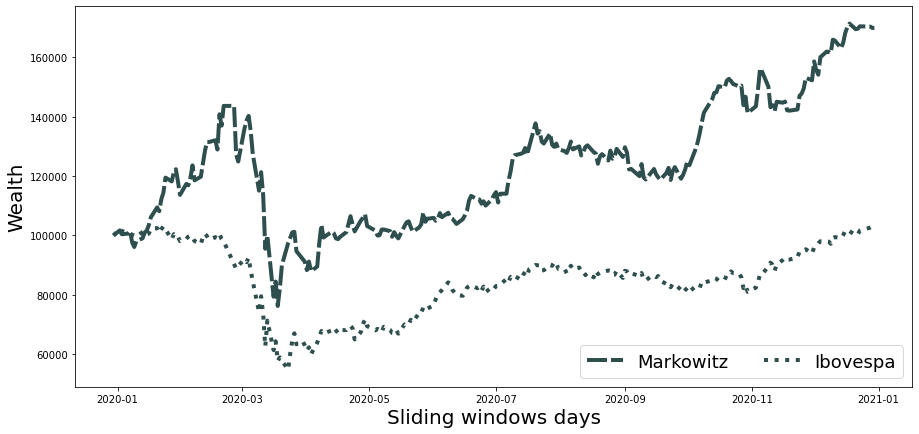

In [15]:
plt.figure(figsize = (15,7))
plt.plot(cumulative_wealth_2020['Cumulative Wealth'],label="Markowitz",color = 'darkslategray',linestyle = (0, (5, 1)), LineWidth = 4)
plt.plot(cumulative_ibovespa_2020['Cumulative Wealth'],label="Ibovespa",color = 'darkslategray',linestyle = ':', LineWidth = 4)
legend = plt.legend(loc='lower right', shadow=False, fontsize= 18,  ncol = 2)
plt.xlabel('Sliding windows days', fontsize=20)
plt.ylabel('Wealth', fontsize=20)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.show()